
### Търсене и извличане на информация. Приложение на дълбоко машинно обучение
### Стоян Михов
### Зимен семестър 2025/2026

## Упражнение 6

За да работи програмата трябва корпуса от публицистични текстове за Югоизточна Европа,
да се намира разархивиран в наддиректорията, в която е програмата (виж упражнение 2).

Преди да се стартира програмата е необходимо да се активира съответното обкръжение с командата:
conda activate tii

In [1]:
import time
import sys
import numpy as np
import nltk
import pprint
from nltk.corpus import PlaintextCorpusReader

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

import numpy as np
from sklearn.decomposition import IncrementalPCA
from sklearn.decomposition import TruncatedSVD

In [2]:
class progressBar:
    def __init__(self ,barWidth = 50):
        self.barWidth = barWidth
        self.period = None
    def start(self, count):
        self.item=0
        self.period = int(count / self.barWidth)
        sys.stdout.write("["+(" " * self.barWidth)+"]")
        sys.stdout.flush()
    def tick(self):
        if self.item>0 and self.item % self.period == 0:
            progress = self.item // self.period
            sys.stdout.write(f"\r[{'-'* progress}{' '*(self.barWidth - progress)}]")
            sys.stdout.flush()
        self.item += 1
    def stop(self):
        sys.stdout.write("\r["+("-" * self.barWidth)+"]\n")

In [3]:
countries = ["Bulgaria", "USA", "China", "North Macedonia", "Nigeria"]
flags = ["🇳🇴", "🇺🇸", "🇨🇳", "🇮🇳", "🇳🇬"]
# Features: [GDP(k$), Life Expectancy, EDUIndex(%)]
X = np.array([
    [17, 76, 77],
    [85, 80, 91],
    [13, 78, 69],
    [9, 77, 70],
    [0.8, 55, 55]
], dtype=float)

In [4]:
def plot_3D(X, countries):
    fig = plt.figure(figsize=(7,6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X[:,0], X[:,1], X[:,2], s=70, c='royalblue')

    for i, c in enumerate(countries):
        ax.text(X[i,0]+1, X[i,1], X[i,2]+0.005, c)
    plt.show()

def plot_2D(X, countries):
    fig = plt.figure(figsize=(7,6))
    ax = fig.add_subplot(111) 
    ax.scatter(X[:,0], X[:,1], s=70, c='royalblue')

    for i, c in enumerate(countries):
        ax.text(X[i,0]+0.5, X[i,1]+0.02, c)

    plt.show()

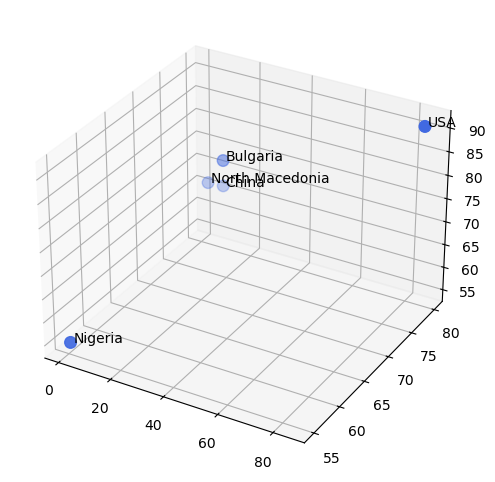

In [5]:
plot_3D(X, countries)

In [6]:
countries = ["Bulgaria", "USA", "China", "North Macedonia", "Nigeria"]
# Features: [GDP(k$), Life Expectancy, EDUIndex(%), HealthIndex(%)]
X = np.array([
    [17, 76, 77, 58],
    [85, 80, 91, 68],
    [13, 78, 69, 68],
    [9, 77, 70, 55],
    [0.8, 55, 55, 48]
], dtype=float)

In [7]:
def pca_manual(X, k=2):
    X_centered = X - np.mean(X, axis=0)
    n = X_centered.shape[0]
    cov_matrix = (X_centered.T @ X_centered) / (n - 1)
    # cov_matrix = np.cov(X_centered, rowvar=False)
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvectors = eigenvectors[:, sorted_indices[:k]]
    return X_centered @ eigenvectors

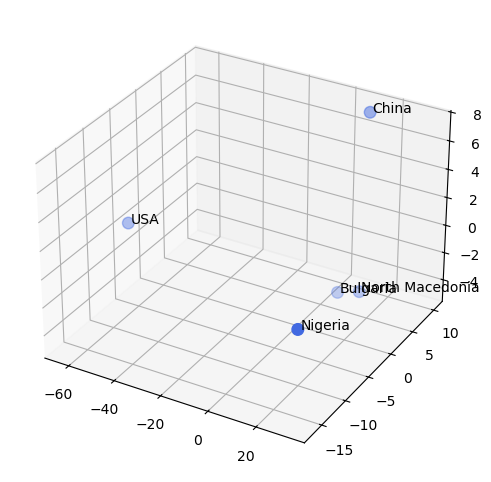

In [8]:
X_pca_3d = pca_manual(X, k=3)
plot_3D(X_pca_3d, countries)

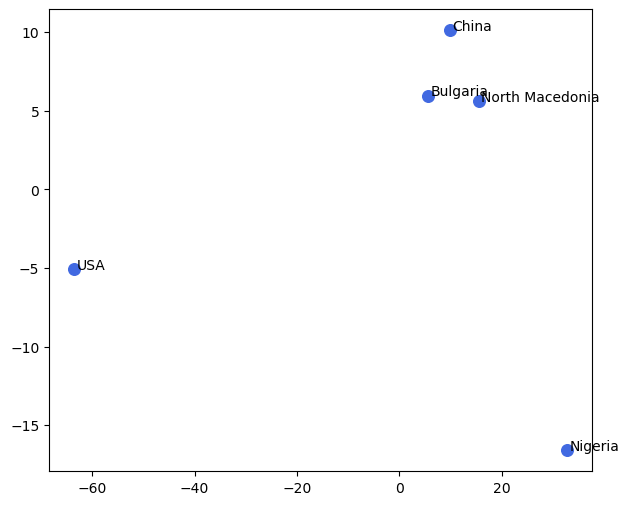

In [9]:
X_pca_2d = pca_manual(X, k=2)
plot_2D(X_pca_2d, countries)

In [10]:
def PCA_k_dim(X, k=2):
    # Документация на метода има на https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.IncrementalPCA.html

    print("Running Incremental PCA over %i words..." % (X.shape[0]))
    X0 = X - np.mean(X, axis=0)
    pca = IncrementalPCA(n_components=k)
    pca.fit(X0)
    X_reduced = pca.transform(X0)
    print("Done.")
    return X_reduced

Running Incremental PCA over 5 words...
Done.


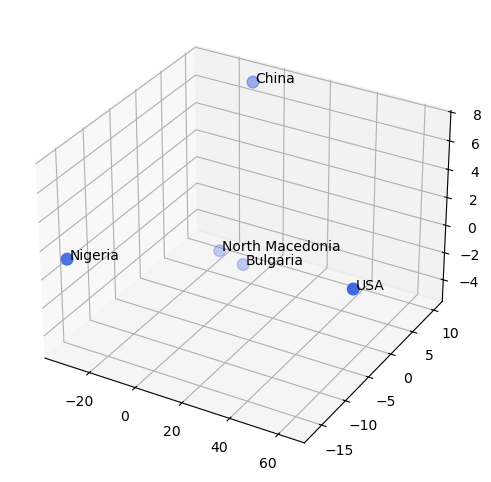

In [11]:
X_3d = PCA_k_dim(X, k=3)
# X_3d[:,0] *= -1
plot_3D(X_3d, countries)

In [12]:
def extractDictionary(corpus, limit=20000):
    pb = progressBar()
    pb.start(len(corpus))
    dictionary = {}
    for doc in corpus:
        pb.tick()
        for w in doc:
            if w not in dictionary: dictionary[w] = 0
        dictionary[w] += 1
    L = sorted([(w,dictionary[w]) for w in dictionary], key = lambda x: x[1] , reverse=True)
    if limit > len(L): limit = len(L)
    words = [ w for w,_ in L[:limit] ]
    word2ind = { w:i for i,w in enumerate(words)}
    pb.stop()
    return words, word2ind


In [13]:
def co_occurrence_matrix(corpus, window_size=4, limit=20000):
    words, word2ind = extractDictionary(corpus,limit=limit)
    num_words = len(words)
    
    X=np.zeros((num_words,num_words))
    
    pb = progressBar()
    pb.start(len(corpus))
    for doc in corpus:
        pb.tick()
        for wi in range(len(doc)):
            if doc[wi] not in word2ind: continue
            i=word2ind[doc[wi]]
            for k in range(1,window_size+1):
                if wi-k>=0 and doc[wi-k] in word2ind:
                    j=word2ind[doc[wi-k]]
                    X[i,j] += 1
                if wi+k<len(doc) and doc[wi+k] in word2ind:
                    j=word2ind[doc[wi+k]]
                    X[i,j] += 1
    pb.stop()
    return X, words, word2ind

In [14]:
def PMI_matrix(C):
    rowSums = np.sum(C,axis=1)
    colSums = np.sum(C,axis=0)
    D = np.sum(rowSums)
    Z = np.outer(rowSums,colSums)
    X = np.maximum(np.log( D * C / Z),0)
    return X

In [15]:
def SVD_k_dim(X, k=100, n_iters = 10):
    # Документация на метода има на https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html
    
    print("Running Truncated SVD over %i words..." % (X.shape[0]))
    svd = TruncatedSVD(n_components=k, n_iter=n_iters)
    svd.fit(X)
    X_reduced = svd.transform(X)
    print("Done.")
    return X_reduced


In [16]:
def plot_embeddings(M, word2ind, words):
    xs = M[:,0]
    ys = M[:,1]
    for w in words:
        i=word2ind[w]
        plt.scatter(xs[i],ys[i], marker='x', color= 'red')
        plt.text(xs[i]+0.001, ys[i]+0.001, w)
    plt.show()

In [17]:
def plot_embeddings_3d(M, word2ind, words):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    xs = M[:,0]
    ys = M[:,1]
    zs = M[:,2]
    for w in words:
        i=word2ind[w]
        ax.scatter(xs[i], ys[i], zs[i], marker='x', color= 'red')
        ax.text(xs[i]+0.001, ys[i]+0.001, zs[i]+0.001, w)
    plt.show()

Малък пример

In [18]:
text = '''
    две хубави очи душата на дете
    в две хубави очи музика лъчи
    не искат и не обещават те
    душата ми се моли
    дете
    душата ми се моли
    страсти и неволи
    ще хвърлят утре върху тях
    булото на срам и грях
    булото на срам и грях
    не ще го хвърлят върху тях
    страсти и неволи
    душата ми се моли
    дете
    душата ми се моли
    не искат и не обещават те
    две хубави очи музика лъчи
    в две хубави очи душата на дете
    '''

[--------------------------------------------------]
[--------------------------------------------------]
Running Truncated SVD over 10 words...
Done.


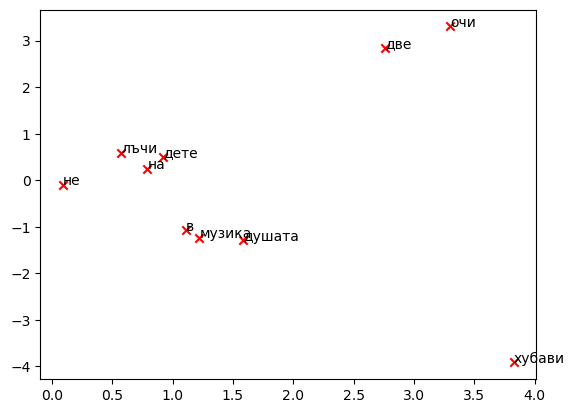

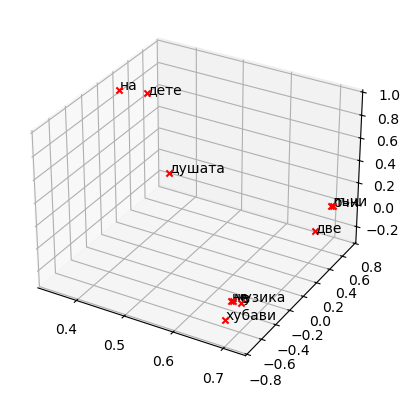

In [19]:
CC,ccww,ccwi = co_occurrence_matrix([text.split()], window_size=1, limit=10)
CC_reduced =SVD_k_dim(CC,k=3)
plot_embeddings(CC_reduced, ccwi, ccww)

# Документация за np.linalg.norm има на https://numpy.org/doc/stable/reference/generated/numpy.linalg.norm.html
CC_lengths = np.linalg.norm(CC_reduced, axis=1)[:, np.newaxis]
CC_normalized = CC_reduced / CC_lengths
plot_embeddings_3d(CC_normalized, ccwi, ccww)

Running Incremental PCA over 10 words...
Done.


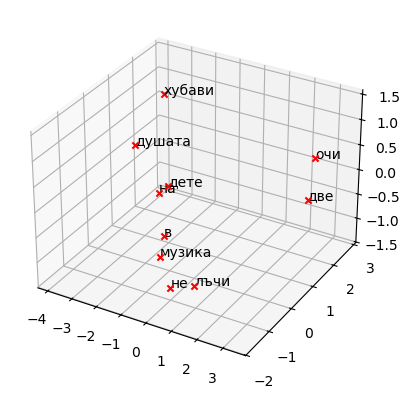

In [20]:
CC_pca = PCA_k_dim(CC, k=3)
plot_embeddings_3d(CC_pca, ccwi, ccww)

# Пълен пример

In [21]:
corpus_root = '../JOURNALISM.BG/C-MassMedia'
myCorpus = PlaintextCorpusReader(corpus_root, '.*\.txt')
startToken = '<START>'
endToken = '<END>'
corpus =  [[startToken] + [w.lower() for w in myCorpus.words(f)] + [endToken] for f in myCorpus.fileids()]

sampleWords = ['кола', 'автомобил', 'румъния', 'министър', 'президент', 'гърция', 'футбол', 'спорт', 'баскетбол', 'българия', 'театър', 'кино', 'опера']

<>:2: SyntaxWarning: invalid escape sequence '\.'
<>:2: SyntaxWarning: invalid escape sequence '\.'
C:\Users\Rumen\AppData\Local\Temp\ipykernel_21720\4211135337.py:2: SyntaxWarning: invalid escape sequence '\.'
  myCorpus = PlaintextCorpusReader(corpus_root, '.*\.txt')


In [22]:
C, words, word2ind = co_occurrence_matrix(corpus, window_size=3, limit=20000)
C_reduced = SVD_k_dim(C)

[--------------------------------------------------]
[--------------------------------------------------]
Running Truncated SVD over 20000 words...
Done.


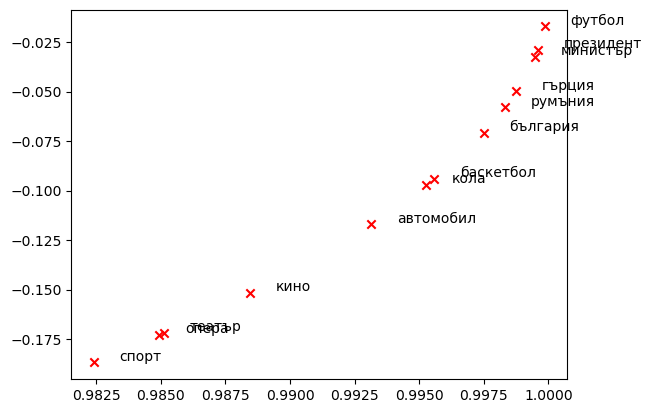

In [23]:
C_reduced_2d = C_reduced[:,:2]
C_lengths_2d = np.linalg.norm(C_reduced_2d, axis=1)
C_normalized_2d = C_reduced_2d / C_lengths_2d[:, np.newaxis]
plot_embeddings(C_normalized_2d, word2ind, sampleWords)

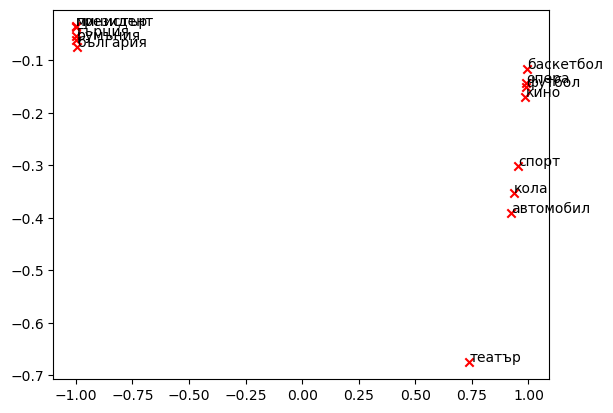

In [24]:
C_PCA_2d = pca_manual(C, k=2)
C_lengths_PCA_2d = np.linalg.norm(C_PCA_2d, axis=1)
C_normalized_PCA_2d = C_PCA_2d / C_lengths_PCA_2d[:, np.newaxis]
plot_embeddings(C_normalized_PCA_2d, word2ind, sampleWords)

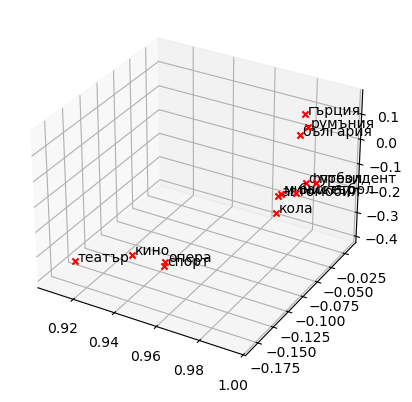

In [25]:
C_reduced_3d = C_reduced[:,:3]
C_lengths_3d = np.linalg.norm(C_reduced_3d, axis=1)
C_normalized_3d = C_reduced_3d / C_lengths_3d[:, np.newaxis]

plot_embeddings_3d(C_normalized_3d, word2ind, sampleWords)

In [26]:
X = PMI_matrix(C)
X_reduced = SVD_k_dim(X)

C:\Users\Rumen\AppData\Local\Temp\ipykernel_21720\1437404356.py:6: RuntimeWarning: divide by zero encountered in log
  X = np.maximum(np.log( D * C / Z),0)


Running Truncated SVD over 20000 words...
Done.


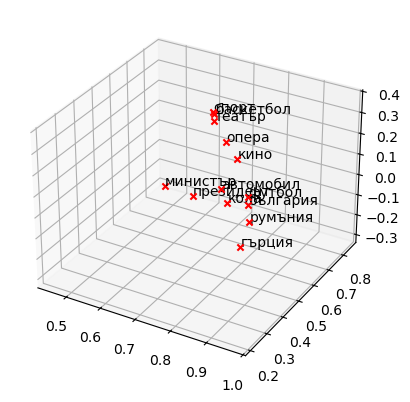

In [27]:
X_reduced_3d = X_reduced[:,:3]
X_lengths_3d = np.linalg.norm(X_reduced_3d, axis=1)
X_normalized_3d = X_reduced_3d / X_lengths_3d[:, np.newaxis]
plot_embeddings_3d(X_normalized_3d, word2ind, sampleWords)

In [28]:
C_lengths_100d = np.linalg.norm(C_reduced, axis=1)
C_normalized_100d = C_reduced / C_lengths_100d[:, np.newaxis]

X_lengths_100d = np.linalg.norm(X_reduced, axis=1)
X_normalized_100d = X_reduced / X_lengths_100d[:, np.newaxis]

In [29]:
def most_similar(w,word2ind,words,C,limit=10):
    i = word2ind[w]
    L = np.dot(C,C[i]).tolist()
    L = sorted([(words[i],s) for i,s in enumerate(L)], key = lambda x: x[1] , reverse=True)
    return L[:limit]

In [30]:
pprint.pprint(most_similar('гърция',word2ind,words,C_normalized_100d))
pprint.pprint(most_similar('футбол',word2ind,words,C_normalized_100d))
pprint.pprint(most_similar('камион',word2ind,words,C_normalized_100d))

[('гърция', 0.9999999999999992),
 ('хърватия', 0.990581924912068),
 ('албания', 0.9881612192325668),
 ('македония', 0.9834435129730594),
 ('румъния', 0.9803282579084087),
 ('турция', 0.9784959004946927),
 ('българия', 0.9782749048309913),
 ('хърватска', 0.9719402972179352),
 ('катар', 0.963030968143402),
 ('maкедония', 0.9628175004313166)]
[('футбол', 1.0000000000000002),
 ('баскетбол', 0.9620013528719303),
 ('атлетика', 0.9472187919468265),
 ('топка', 0.9459278445715911),
 ('щефан', 0.9454812235651592),
 ('хандбал', 0.9423157717141376),
 ('телевизията', 0.9402813605279916),
 ('волейбол', 0.9401715179068151),
 ('водна', 0.9294323304367489),
 ('гребане', 0.926982121432131)]
[('камион', 1.0),
 ('галичник', 0.9718276937460804),
 ('районите', 0.9624413920891108),
 ('съревнование', 0.9573916561205924),
 ('автомобил', 0.9505256883224982),
 ('плуването', 0.9493984425324611),
 ('кола', 0.9481278952262305),
 ('областите', 0.9477254985497323),
 ('грачаница', 0.9465299188367241),
 ('морето', 0.94

In [31]:
pprint.pprint(most_similar('гърция',word2ind,words,X_normalized_100d))
pprint.pprint(most_similar('футбол',word2ind,words,X_normalized_100d))
pprint.pprint(most_similar('камион',word2ind,words,X_normalized_100d))

[('гърция', 1.0),
 ('турция', 0.8493604446065237),
 ('албания', 0.7982202441856758),
 ('румъния', 0.797779095129728),
 ('българия', 0.7952858210600159),
 ('хърватия', 0.7760441964002631),
 ('македония', 0.7729354005305782),
 ('кипър', 0.7580692752490279),
 ('страната', 0.7229012653270688),
 ('сърбия', 0.7192050414247686)]
[('футбол', 1.0),
 ('баскетбол', 0.8795117051077882),
 ('хандбал', 0.8500287605572922),
 ('отбор', 0.8324724518619244),
 ('волейбол', 0.8120876391152154),
 ('топка', 0.8022594135331023),
 ('водна', 0.7964868909323335),
 ('квалификациите', 0.7949052984227611),
 ('уефа', 0.7844284753687205),
 ('хокей', 0.774351997366151)]
[('камион', 0.9999999999999996),
 ('автомобил', 0.822562999432263),
 ('кола', 0.7682680858579333),
 ('колата', 0.7622797652799043),
 ('огън', 0.7476429203491182),
 ('влак', 0.7437156440635857),
 ('сблъсък', 0.7216235159855449),
 ('контейнер', 0.7197767801226411),
 ('скрити', 0.7117333767471579),
 ('загина', 0.7031998475445461)]
